In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

## Classical Models

In [2]:
# Load data
df = pd.read_csv('manual_cleaned_emotion_classify_data.csv')

# spaCy pipeline
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha  # remove stopwords & non-letters
    ]
    return " ".join(tokens)

In [3]:
# Apply lemmatization + stopword removal
df['text_proc'] = df['Comment_clean'].astype(str).apply(preprocess)

X = df['text_proc']
y = df['Emotion'].astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y)


In [4]:
results = {}

Logistic Regression

In [ ]:
# Define pipeline: TF-IDF -> Logistic Regression
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
])

# TF-IDF + Logistic Regression hyperparameters
param_grid_lr = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__sublinear_tf': [True],

    'clf__C': [0.01, 0.1, 1, 3, 10],
    'clf__class_weight': [None, 'balanced']
}

# Grid search
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR CV score:", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
Best LR params: {'clf__C': 10, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.85, 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}
Best LR CV score: 0.9309328279637817


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [13]:
y_pred_lr = best_lr.predict(X_test)

results['Logistic Regression (tuned)'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'report': classification_report(y_test, y_pred_lr, output_dict=True)
}


Linear SVM (LinearSVC) + TF-IDF tuning

In [ ]:
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

param_grid_svm = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__sublinear_tf': [True],

    'clf__C': [0.01, 0.1, 1, 3, 10, 30],
    'clf__class_weight': [None, 'balanced'],
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__max_iter': [1000, 3000, 5000],
}

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid=param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print("Best SVM params:", grid_svm.best_params_)

y_pred_svm = best_svm.predict(X_test)
results['Linear SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'report': classification_report(y_test, y_pred_svm, output_dict=True)
}


Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
Best SVM params: {'clf__C': 1, 'clf__class_weight': None, 'clf__loss': 'hinge', 'clf__max_iter': 1000, 'tfidf__max_df': 0.95, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}


Multinomial Naive Bayes + TF-IDF tuning

In [ ]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid_nb = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__sublinear_tf': [True],

    'clf__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
    'clf__fit_prior': [True, False],
}

grid_nb = GridSearchCV(
    pipe_nb,
    param_grid=param_grid_nb,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_nb.fit(X_train, y_train)
best_nb = grid_nb.best_estimator_
print("Best NB params:", grid_nb.best_params_)

y_pred_nb = best_nb.predict(X_test)
results['Naive Bayes'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'report': classification_report(y_test, y_pred_nb, output_dict=True)
}


Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best NB params: {'clf__alpha': 2.0, 'clf__fit_prior': True, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}


Random Forest + TF-IDF (RandomizedSearch)

In [ ]:
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist_rf = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__sublinear_tf': [True],

    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 10, 20, 30, 40],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__bootstrap': [True, False],
}

rf_random = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=40,          # number of random combos to try
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print("Best RF params:", rf_random.best_params_)

y_pred_rf = best_rf.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'report': classification_report(y_test, y_pred_rf, output_dict=True)
}


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best RF params: {'tfidf__sublinear_tf': True, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_features': 5000, 'tfidf__max_df': 0.9, 'clf__n_estimators': 500, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': None, 'clf__max_depth': None, 'clf__bootstrap': True}


XGBoost + TF-IDF

In [ ]:
# Encode labels
le_xgb = LabelEncoder()
y_train_xgb = le_xgb.fit_transform(y_train)
y_test_xgb = le_xgb.transform(y_test)

pipe_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(
        objective='multi:softmax',
        num_class=len(le_xgb.classes_),
        eval_metric='mlogloss',
        tree_method='hist',
        n_jobs=-1,
        use_label_encoder=False
    ))
])

param_dist_xgb = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__sublinear_tf': [True],

    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.7, 0.9, 1.0],
    'clf__colsample_bytree': [0.7, 0.9, 1.0],
}

xgb_random = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=25,
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random.fit(X_train, y_train_xgb)
best_xgb = xgb_random.best_estimator_
print("Best XGB params:", xgb_random.best_params_)

y_pred_xgb_enc = best_xgb.predict(X_test)
y_pred_xgb = le_xgb.inverse_transform(y_pred_xgb_enc)

results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'report': classification_report(y_test, y_pred_xgb, output_dict=True)
}


Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:09:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params: {'tfidf__sublinear_tf': True, 'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 2, 'tfidf__max_features': 10000, 'tfidf__max_df': 0.95, 'clf__subsample': 1.0, 'clf__n_estimators': 300, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7}


In [25]:
results

{'Logistic Regression (tuned)': {'accuracy': 0.9377104377104377,
  'report': {'anger': {'precision': 0.9348370927318296,
    'recall': 0.9325,
    'f1-score': 0.9336670838548186,
    'support': 400.0},
   'fear': {'precision': 0.9396325459317585,
    'recall': 0.9226804123711341,
    'f1-score': 0.9310793237971391,
    'support': 388.0},
   'joy': {'precision': 0.9387254901960784,
    'recall': 0.9575,
    'f1-score': 0.948019801980198,
    'support': 400.0},
   'accuracy': 0.9377104377104377,
   'macro avg': {'precision': 0.9377317096198888,
    'recall': 0.9375601374570447,
    'f1-score': 0.937588736544052,
    'support': 1188.0},
   'weighted avg': {'precision': 0.9377125092531022,
    'recall': 0.9377104377104377,
    'f1-score': 0.9376544881879602,
    'support': 1188.0}}},
 'Linear SVM (tuned)': {'accuracy': 0.936026936026936,
  'report': {'anger': {'precision': 0.9292929292929293,
    'recall': 0.92,
    'f1-score': 0.9246231155778895,
    'support': 400.0},
   'fear': {'precis

In [21]:
rows = []
for model, vals in results.items():
    acc = vals['accuracy']
    report = vals['report']
    for cls, metrics in report.items():
        if cls != 'accuracy':
            row = {'model': model, 'class': cls, 'accuracy': acc}
            row.update(metrics)
            rows.append(row)

df = pd.DataFrame(rows)
path = "classical_model_macro_results.csv"
df.to_csv(path, index=False)
path


'classical_model_macro_results.csv'

## Graphs

In [ ]:
classical_results_df = pd.read_csv('classical_model_macro_results.csv')

In [24]:
classical_results_df.set_index('model')
classical_results_df

,model,class,accuracy,precision,recall,f1-score,support
0,Logistic Regression,anger,0.937710,0.934837,0.932500,0.933667,400.0
1,Logistic Regression,fear,0.937710,0.939633,0.922680,0.931079,388.0
2,Logistic Regression,joy,0.937710,0.938725,0.957500,0.948020,400.0
3,Logistic Regression,macro avg,0.937710,0.937732,0.937560,0.937589,1188.0
4,Logistic Regression,weighted avg,0.937710,0.937713,0.937710,0.937654,1188.0
5,Linear SVM,anger,0.936027,0.929293,0.920000,0.924623,400.0
6,Linear SVM,fear,0.936027,0.930591,0.932990,0.931789,388.0
7,Linear SVM,joy,0.936027,0.947891,0.955000,0.951432,400.0
8,Linear SVM,macro avg,0.936027,0.935925,0.935997,0.935948,1188.0
9,Linear SVM,weighted avg,0.936027,0.935979,0.936027,0.935990,1188.0


Accuracy comparison

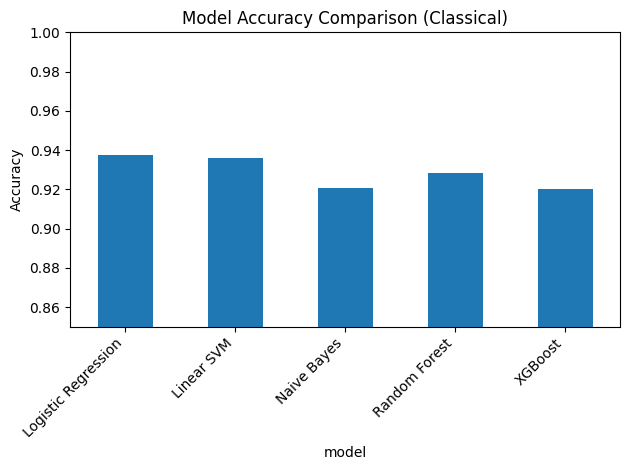

In [26]:
acc_df = classical_results_df[classical_results_df["class"] == "macro avg"][["model", "accuracy"]]

acc_df = acc_df.set_index("model")

acc_df.plot(kind="bar", legend=False)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Classical)")
plt.ylim(0.85, 1.0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Macro precision, recall, F1 per model

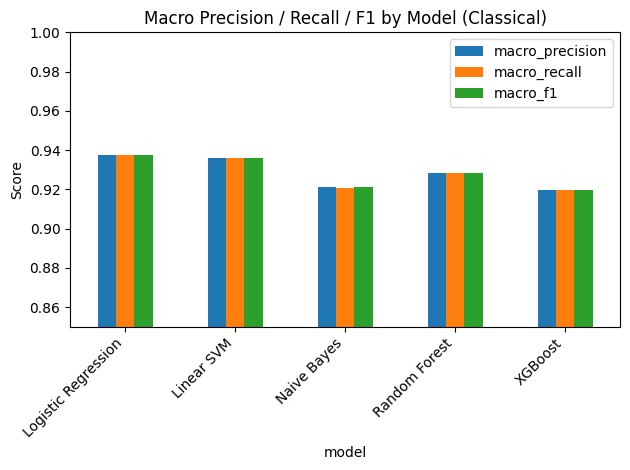

In [27]:
macro_df = classical_results_df[classical_results_df["class"] == "macro avg"][["model", "precision", "recall", "f1-score"]]

macro_df = macro_df.set_index("model")
macro_df.columns = ["macro_precision", "macro_recall", "macro_f1"]

macro_df.plot(kind="bar")
plt.ylabel("Score")
plt.title("Macro Precision / Recall / F1 by Model (Classical)")
plt.ylim(0.85, 1.0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Per-class F1-score comparison across models

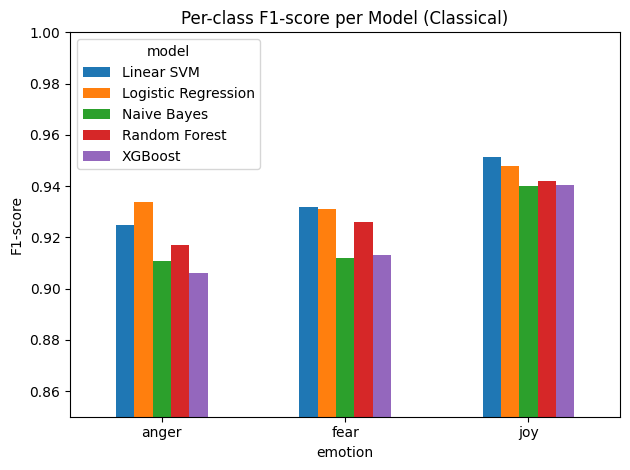

In [28]:
classes = ["anger", "fear", "joy"]

per_class = classical_results_df[classical_results_df["class"].isin(classes)].copy()

per_class_df = per_class[["model", "class", "f1-score"]]
per_class_df = per_class_df.rename(columns={"class": "emotion", "f1-score": "f1"})

pivot_f1 = per_class_df.pivot(index="emotion", columns="model", values="f1")

pivot_f1.plot(kind="bar")
plt.ylabel("F1-score")
plt.title("Per-class F1-score per Model (Classical)")
plt.ylim(0.85, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## SHAP

In [7]:
import shap
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Rebuild from the best params
best_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 3),
        min_df=1,
        max_df=0.85,
        sublinear_tf=True
    )),
    ('clf', LogisticRegression(
        max_iter=500,
        solver='liblinear',
        C=10,
        class_weight='balanced'
    ))
])

# Fit once (much cheaper than full grid search)
best_lr.fit(X_train, y_train)


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
# Get fitted steps
vectorizer = best_lr.named_steps['tfidf']
clf        = best_lr.named_steps['clf']

# Transform data
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# Create SHAP explainer
explainer = shap.LinearExplainer(clf, X_train_tfidf)
shap_values = explainer.shap_values(X_test_tfidf)

shap.initjs()


In [ ]:
# pick an example from test set
i = 0

text_example = X_test.iloc[i]
true_label   = y_test.iloc[i]
pred_label   = best_lr.predict([text_example])[0]

print("Text:", text_example)
print("True emotion:", true_label)
print("Predicted emotion:", pred_label)

# class index of predicted label
class_names = clf.classes_
pred_class_index = np.where(class_names == pred_label)[0][0]

shap_vals_example = shap_values[i, :, pred_class_index]  # length = n_features
feature_names = vectorizer.get_feature_names_out()

example_tfidf = X_test_tfidf[i]
nonzero_idx = example_tfidf.nonzero()[1]

word_contribs = []
for idx in nonzero_idx:
    word = feature_names[idx]
    sv   = shap_vals_example[idx]
    tfidf_val = example_tfidf[0, idx]
    word_contribs.append((word, sv, tfidf_val))

word_contribs_sorted = sorted(word_contribs, key=lambda x: abs(x[1]), reverse=True) # sort by abs(SHAP)

print("\nTop contributing words for predicted emotion:", pred_label)
for word, sv, tfidf_val in word_contribs_sorted[:15]:
    direction = "↑ pushes towards this emotion" if sv > 0 else "↓ pushes away from this emotion"
    print(f"{word:20s}  SHAP = {sv: .4f}  ({direction})")


Text: feel excited eager
True emotion: joy
Predicted emotion: joy

Top contributing words for predicted emotion: joy
eager                 SHAP =  2.6000  (↑ pushes towards this emotion)
feel excited          SHAP =  2.1774  (↑ pushes towards this emotion)
excited               SHAP =  1.9708  (↑ pushes towards this emotion)


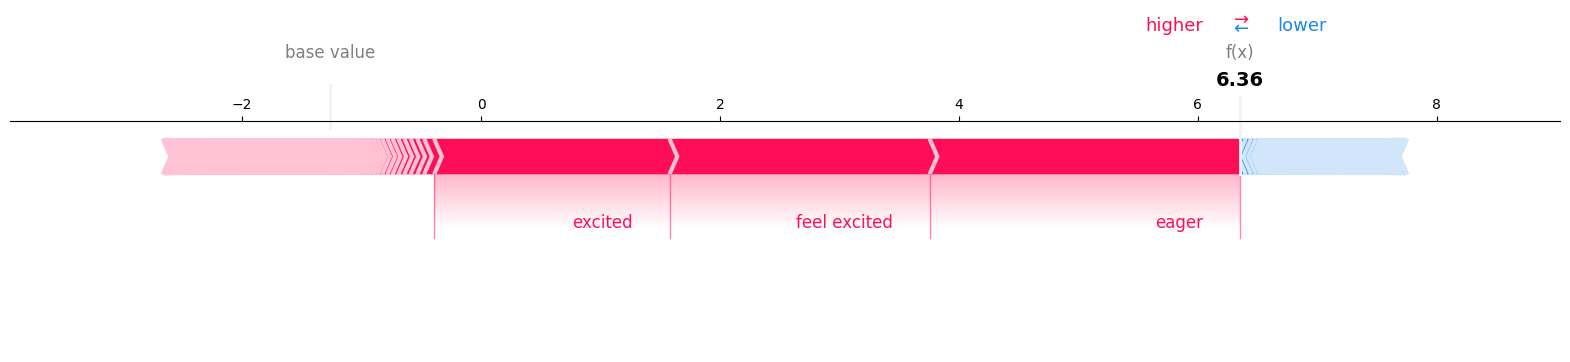

In [21]:
shap.initjs()

shap.force_plot(
    explainer.expected_value[pred_class_index],
    shap_vals_example,
    feature_names=feature_names,
    matplotlib=True 
)


In [22]:
def get_example_for_emotion(emotion):
    idx = np.where(y_test.values == emotion)[0][0]
    return idx, X_test.iloc[idx], y_test.iloc[idx]
    
idx_ang, text_ang, label_ang = get_example_for_emotion("anger")
idx_joy, text_joy, label_joy = get_example_for_emotion("joy")
idx_fear, text_fear, label_fear = get_example_for_emotion("fear")

print("ANGER EXAMPLE:", text_ang)
print("JOY EXAMPLE:", text_joy)
print("FEAR EXAMPLE:", text_fear)


ANGER EXAMPLE: classmate get b homework get c get result act merit grade find humility hypocritical find disgusting
JOY EXAMPLE: feel excited eager
FEAR EXAMPLE: believe display deep emotional yearning semblance normality peace appear dancing arab feel threaten fully armed soldier


In [27]:
def explain_text(index):
    text = X_test.iloc[index]
    true_label = y_test.iloc[index]
    pred_label = best_lr.predict([text])[0]

    print("TEXT:", text)
    print("True Emotion:", true_label)
    print("Predicted Emotion:", pred_label)

    class_names = clf.classes_
    pred_class_index = np.where(class_names == pred_label)[0][0]

    shap_vals_example = shap_values[index, :, pred_class_index]

    feature_names = vectorizer.get_feature_names_out()
    example_tfidf = X_test_tfidf[index]

    nonzero_idx = example_tfidf.nonzero()[1]
    word_contribs = []

    for idx in nonzero_idx:
        word = feature_names[idx]
        sv   = shap_vals_example[idx]
        tfidf_val = example_tfidf[0, idx]
        word_contribs.append((word, sv, tfidf_val))

    word_contribs = sorted(word_contribs, key=lambda x: abs(x[1]), reverse=True)

    print("\nTop contributing words for predicted emotion:", pred_label)
    for word, sv, tfidf_val in word_contribs[:10]:
        direction = "↑ pushes towards this emotion" if sv > 0 else "↓ pushes away"
        print(f"{word:20s}  SHAP={sv: .3f}  ({direction})")

    shap.initjs()
    return shap.force_plot(
        explainer.expected_value[pred_class_index],
        shap_vals_example,
        feature_names=feature_names,
        matplotlib=True
    )


TEXT: classmate get b homework get c get result act merit grade find humility hypocritical find disgusting
True Emotion: anger
Predicted Emotion: anger

Top contributing words for predicted emotion: anger
get                   SHAP= 0.739  (↑ pushes towards this emotion)
get result            SHAP=-0.697  (↓ pushes away)
act                   SHAP= 0.594  (↑ pushes towards this emotion)
grade                 SHAP= 0.551  (↑ pushes towards this emotion)
homework              SHAP=-0.096  (↓ pushes away)
result                SHAP=-0.076  (↓ pushes away)
find                  SHAP= 0.072  (↑ pushes towards this emotion)


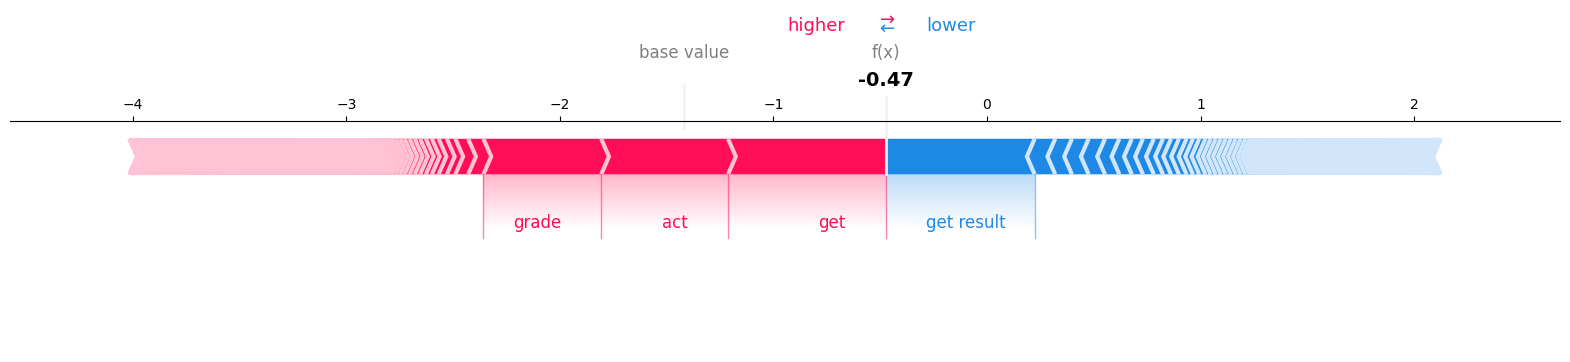

In [28]:
explain_text(idx_ang)

TEXT: feel excited eager
True Emotion: joy
Predicted Emotion: joy

Top contributing words for predicted emotion: joy
eager                 SHAP= 2.600  (↑ pushes towards this emotion)
feel excited          SHAP= 2.177  (↑ pushes towards this emotion)
excited               SHAP= 1.971  (↑ pushes towards this emotion)


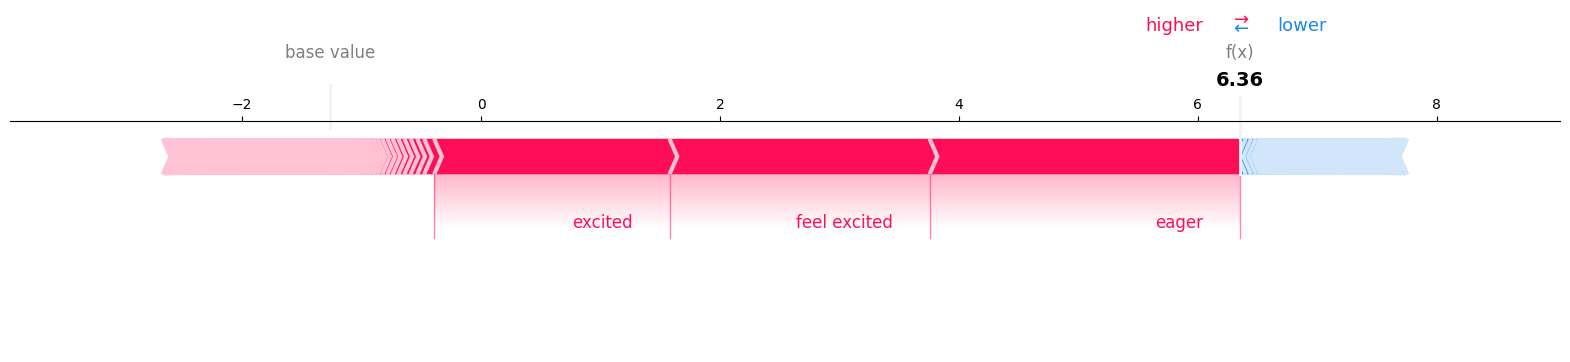

In [29]:
explain_text(idx_joy)


TEXT: believe display deep emotional yearning semblance normality peace appear dancing arab feel threaten fully armed soldier
True Emotion: fear
Predicted Emotion: fear

Top contributing words for predicted emotion: fear
threaten              SHAP= 2.119  (↑ pushes towards this emotion)
feel threaten         SHAP= 1.117  (↑ pushes towards this emotion)
deep                  SHAP= 0.405  (↑ pushes towards this emotion)
believe               SHAP= 0.360  (↑ pushes towards this emotion)
display               SHAP= 0.228  (↑ pushes towards this emotion)
appear                SHAP=-0.187  (↓ pushes away)
emotional             SHAP=-0.079  (↓ pushes away)
peace                 SHAP= 0.033  (↑ pushes towards this emotion)
fully                 SHAP=-0.003  (↓ pushes away)


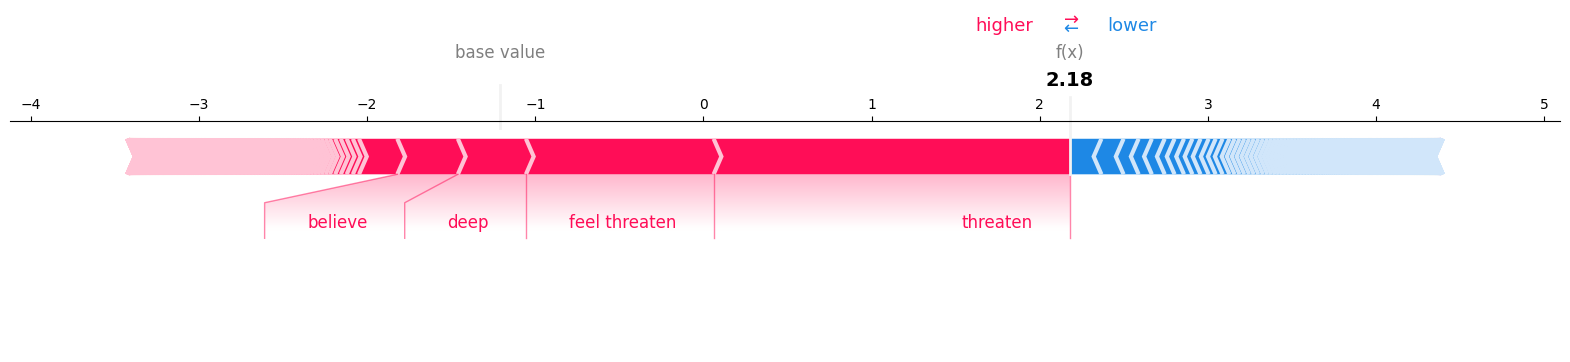

In [30]:
explain_text(idx_fear)
